# Motion Deblur Acquisition Notebook

In [1]:
# Magic Functions
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Misc imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import sleep
import sys, os, time, datetime

# llops imports
from llops import Roi

# Comptic imports
import comptic

# Imports from this library
from htdeblur.acquisition import hardware
from htdeblur import acquisition

# Define micro-manager directory
hardware.mm_directory = 'C:\Program Files\Micro-Manager-2.0beta'

## Create Hardware Controllers

In [2]:
# Define COM ports
led_array_port = "COM7"
xy_stage_port = "COM5"
camera_name = 'pco'

# Delete old devices
if 'led_controller' in locals():
    led_controller.unload()
    
if 'pos_controller' in locals():
    pos_controller.unload()

if 'cam_controller' in locals():
    cam_controller.unload()

# Create LED controller interface
led_controller = hardware.LedArrayController(led_array_port)
led_controller.setupCameraTriggering(pin_index=0)
led_controller.setupMotionStageTriggering(pin_index=1, delay_ms=1)
led_controller.trigger_mode = 'software'
led_controller.clear()

# Create position controller interface
pos_controller = hardware.PositionController(xy_stage_port)

# Create camera controller object
cam_controller = hardware.CameraController(camera_name)
    
# Set up hardware triggering
cam_controller.trigger_mode = 'hardware'
cam_controller.trigger_pin = 0
led_controller.camera_trigger_index = 1

pos_controller.trigger_mode = 'hardware'
pos_controller.trigger_pin = 1
led_controller.motion_stage_trigger_index = 1
led_controller.trigger_frame_time_s = [0, 0]

# Make a list
hardware_controller_list = [led_controller, cam_controller, pos_controller]

# Illuminate the light source as verification
led_controller.bf()

Micro-manager was loaded sucessfully!


## Create data output directory

In [3]:
out_dir = 'D:\\Zack\\' + datetime.date.today().strftime("%m-%d-%y") +'-MotionDeblur\\'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Define System Metadata

In [4]:
# Define LED positions using actual distances from sample
array_z_distance_mm = 60.0

# Load quasi-dome positions
led_controller.array_distance = array_z_distance_mm
source_list_cart = np.asarray(led_controller.led_position_list_cart)
source_list_na_design = np.asarray(led_controller.led_position_list_na)

# Define system metadata
sys_metadata_dict = {
    'objective' :{'na': .25, 'mag' : 10}, # remember to set system_mag to 2. for B (front port)
    'system' : {'mag': 1},
    'illumination' : {"device_name" : led_controller.device_name, "spectrum" : {"center" : {'b' : 0.480, "g" : 0.532, "r" : 0.625}}, 
                      "z_distance_mm" : array_z_distance_mm, "state_list" : {"design" : source_list_na_design, 'units' : 'na'}, 'bit_depth' : led_controller.bit_depth, "device_type" : led_controller.type},
    'position' : {"device_name" : "h117", "state_list" : {'units' : 'mm'}, "device_type" : "xy_stage"}
}

# Create metadata object
sys_metadata = comptic.containers.Metadata(from_dict=sys_metadata_dict)

# Assign wavelengths
sys_metadata.illumination.spectrum.center = led_controller.color_channel_center_wavelengths

# Set up camera
if camera_name == "pco":
    sys_metadata.camera.pixel_size_um = 6.5
    sys_metadata.camera.is_color = False
    sys_metadata.camera.device_name = camera_name
    sys_metadata.camera.port = 'side'
    sys_metadata.system.mag = 1.0
    
    # Geometric transforms
    cam_controller.transpose = False
    cam_controller.flip_x = True
    cam_controller.flip_y = False
    
elif camera_name == "pco_color":
    sys_metadata.camera.pixel_size_um = 6.5 * 2
    sys_metadata.camera.is_color = True
    sys_metadata.camera.device_name = 'pco'
    sys_metadata.camera.port = 'front'
    sys_metadata.system.mag = 1.934

     # Geometric transforms
    cam_controller.transpose = False
    cam_controller.flip_x = True
    cam_controller.flip_y = False
    cam_controller.bayer_coupling_matrix = sys_metadata.camera.bayer_coupling_matrix
    cam_controller.is_color = True

elif camera_name == 'optimos':
    sys_metadata.camera.pixel_size_um = 4.54
    sys_metadata.camera.is_color = True
    sys_metadata.camera.bayer_coupling_matrix = bayer_coupling_matrix
    sys_metadata.system.mag = 2.0
    sys_metadata.camera.port = 'front'
    sys_metadata.camera.device_name = camera_name
    
     # Geometric transforms
    cam_controller.transpose = False
    cam_controller.flip_x = False
    cam_controller.flip_y = False
    cam_controller.bayer_coupling_matrix = sys_metadata.camera.bayer_coupling_matrix
    cam_controller.is_color = True
    
elif camera_name == 'retiga':
    sys_metadata.camera.pixel_size_um = 4.54
    sys_metadata.camera.is_color = False
    sys_metadata.system.mag = 1.0
    sys_metadata.camera.port = 'side'
    sys_metadata.camera.device_name = camera_name
    
     # Geometric transforms
    cam_controller.transpose = False
    cam_controller.flip_x = False
    cam_controller.flip_y = False
    cam_controller.bayer_coupling_matrix = None
    cam_controller.is_color = False
    
else:
    raise ValueError("No camera found!")

# Calculate effective pixel size
sys_metadata.system.eff_pixel_size_um = sys_metadata.camera.pixel_size_um / (sys_metadata.objective.mag * sys_metadata.system.mag)

# Print system metadata
print(sys_metadata)

# Set up led array hardware to use this metadata
led_controller.na = sys_metadata.objective.na
led_controller.array_distance = sys_metadata.illumination.z_distance_mm

# Set up joystick
pos_controller.setJoystickFlip(True, False) # up is +y, right is +x

# Print information about sampling
sys_metadata.checkSampling()

# Display brightfield pattern for alignment
led_controller.bf()

type: None
system: mag: 1.0, image_flip_y: False, image_flip_x: False, eff_pixel_size_um: 0.65
sample: size_mm: None, roi: Roi(), name: None
reconstructions: []
pupil: state_list: units: None, grouping: None, design: None, calibrated: None, device_type: None, device_name: None
position: velocity_mm_s: None, units: mm, state_list: units: mm, grouping: None, design: None, calibrated: None, device_type: xy_stage, device_name: h117, acceleration_mm_s2: None
objective: na: 0.25, mag: 10
illumination: z_distance_mm: 60.0, state_list: units: na, grouping: None, design: [[ 0.  0.]
 [-0.  0.]
 [ 0. -0.]
 [-0. -0.]], calibrated: None, spectrum: units: um, full: None, center: {'w': 0.53}, is_color: False, device_type: illumination, device_name: quadrant-array, bit_depth: 8
groundtruth: parameters: None, object: None
focus: velocity_mm_s: None, state_list: units: None, grouping: None, design: None, calibrated: None, device_type: None, device_name: None, acceleration_mm_s2: None
file_header: None
d

# Live Viewer
Things to do here:
- Ensure the camera doesn't saturate (You want around 40k-50k counts on average
- Ensure motion is linear and not at an angle (use the top of a window to align)

<IPython.core.display.Javascript object>


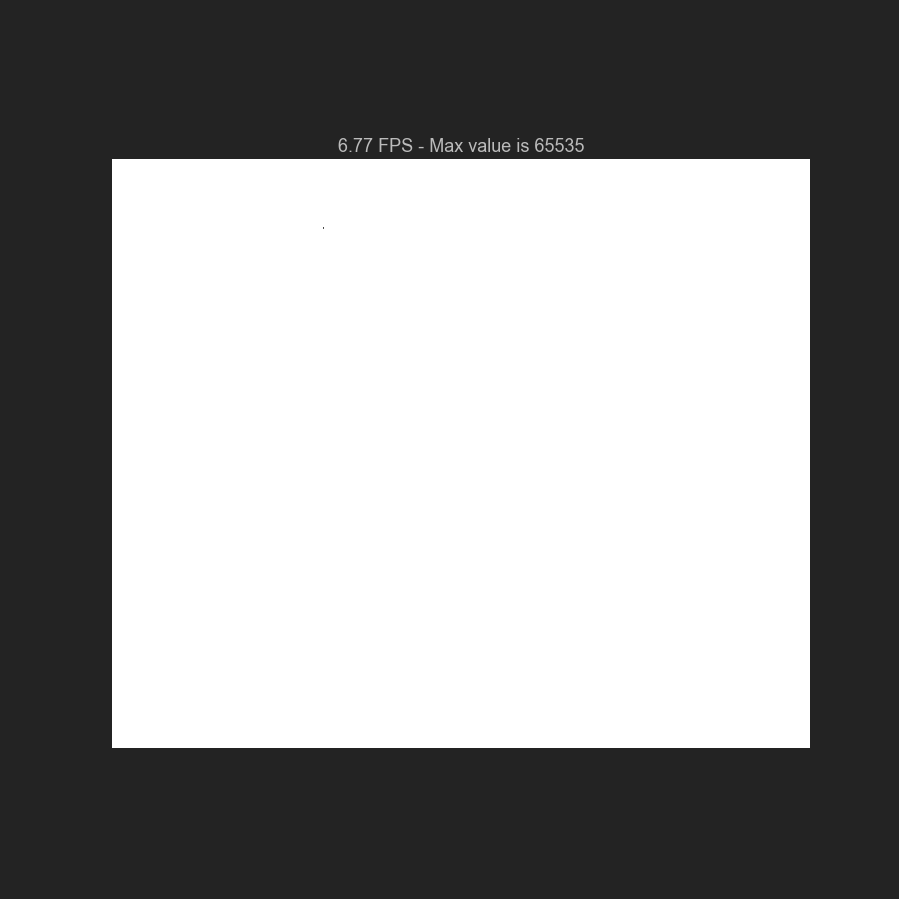

In [5]:
# Illuminate
led_controller.bf()

# Exposure
exposure_time_ms = 1

# Start live view
cam_controller.liveView(figsize=(10,10), contrast_type='fit')

# pos_controller.zero()

## Set up Acquisition

In [6]:
# Reload devices
pos_controller.reload()
led_controller.reload()

# Zero position
pos_controller.zero()

# Define dataset name
sys_metadata.sample.name = 'test'

# Define sample size
sample_size_0 = (3, 3) #(22, 28)

# Overlap parameter (1 = no overlap)
overlap_factor = 0.8

# Append color to sample name if we're using a color camera
if sys_metadata.camera.is_color:
    sys_metadata.sample.name += '_color'

# Calculate FOV
fov = cam_controller.fov(sys_metadata.system.mag * sys_metadata.objective.mag)

# Round up sample size
sys_metadata.sample.size_mm = np.ceil(np.asarray(sample_size_0) / np.asarray((overlap_factor * fov[0], overlap_factor * fov[1]))) * np.asarray((overlap_factor * fov[0], overlap_factor * fov[1]))

# Acquisition

# Background Image Capture
This step captures the background (dust in the system without the sample) as well as the dark current (signal when illumination is off).

<IPython.core.display.Javascript object>


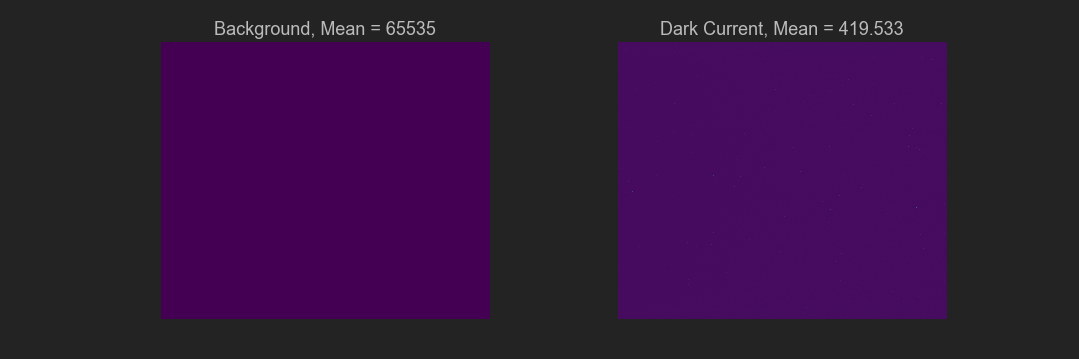

Text(0.5, 1.0, 'Dark Current, Mean = 419.533')

In [7]:
n_avg = 3
sample_free_offset = (0, -25)
exposure_bg = 0.1

# Go to offset position and capture background
pos_controller.goToPosition(sample_free_offset, blocking=True)
cam_controller.setExposure(exposure_bg)
led_controller.bf()
time.sleep(1)
img_bg = cam_controller.snap()

# Turn off Illumination
led_controller.clear()

# Capture dark current image
img_dc = cam_controller.snap()

# Perform averaging
for _ in range(n_avg - 1):
    time.sleep(0.1)
    img_dc += cam_controller.snap()
    
# Normalize
img_dc = img_dc / n_avg

# Go back home
pos_controller.goToPosition((0,0))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(img_bg)
plt.axis('off')
plt.title('Background, Mean = %g' % np.mean(img_bg))
plt.subplot(122)
plt.imshow(img_dc)
plt.axis('off')
plt.title('Dark Current, Mean = %g' % np.mean(img_dc))

## Stop and Stare Acquisition
This step performs a stop-and-stare acquisition

In [9]:
# Create Acquisition Object
sns_acq = acquisition.StopAndStareAcquisition(hardware_controller_list, 
                                              sys_metadata,
                                              frame_spacing_mm=(overlap_factor * fov[0], overlap_factor * fov[1]), # y,x
                                              object_size_mm=sys_metadata.sample.size_mm, # y,x
                                              settle_time_s=0.1)
# Acquire
dataset_sns = sns_acq.acquire(exposure_time_ms=100)

# Save background and dark current
dataset_sns.background = img_bg
dataset_sns.dark_current = img_dc

# Reset Stage
pos_controller.goToPosition((0,0))

# Save 
meta = dataset_sns.save(out_dir, header=sys_metadata.sample.name + '_stopandstare', bit_depth=16)

Image size requires 3 x 3 images


Acquisition took 8.9920 seconds
Wrote tiff file to file: D:/Zack/04-23-19-MotionDeblur/test_stopandstare_stop and stare_2019_04_23_09_49_44/test_stopandstare_stop and stare_2019_04_23_09_49_44.tif
Wrote background tiff file to file: D:/Zack/04-23-19-MotionDeblur/test_stopandstare_stop and stare_2019_04_23_09_49_44/background.tif
Wrote dark current tiff file to file: D:/Zack/04-23-19-MotionDeblur/test_stopandstare_stop and stare_2019_04_23_09_49_44/dark_current.tif


## Motion Deblur Acquisition

In [10]:
# Re-initialize position controller
pos_controller.reload()
pos_controller.goToPositionRapid((0,0), blocking=True)
pos_controller.setAcceleration(8e2)

# Derivative of acceleration
pos_controller.jerk = 7423223

# Trigger pulse width
pos_controller.trigger_pulse_width_us = 2000

# Re-initialize led controller
led_controller.reload()
led_controller.bf()
led_controller.command_debug = False

# Stepper motor speed
pos_controller.command('SS 1')

# Disable encoders
pos_controller.command('ENCODER X 0')
pos_controller.command('ENCODER Y 0')

# Reset 
led_controller.trigger_frame_time_s = [0, 0]

In [11]:
# Generate acquisition object using options above
md_acq = acquisition.MotionDeblurAcquisition(hardware_controller_list, 
                                             sys_metadata, 
                                             frame_spacing_mm=(overlap_factor * fov[0], overlap_factor * fov[1]), # x,y
                                             object_size_mm=sys_metadata.sample.size_mm, # x,y
                                             saturation_factor=0.5, #1/8
                                             extra_run_up_time_s=0.1,
                                             kernel_pulse_count=10,
                                             velocity_mm_s=25,
                                             motion_path_type="raster",
                                             blur_vector_method="coded",
                                             use_l1_distance_for_motion_calculations=True,
                                             segment_delay_s=0.0)

# Acquire
dataset = md_acq.acquire(reset_devices=False)

# Save background and dark current
dataset.background = img_bg
dataset.dark_current = img_dc

# Save results
meta = dataset.save(out_dir, 
                    header=sys_metadata.sample.name + '_' + md_acq.blur_vector_method + '_' + md_acq.motion_path_type + '_' + str(md_acq.kernel_pulse_count))

Image size requires 3 x 3 images
Generated motion pathway with 3 linear segments
Found 3 segments and 9 frames
Starting linear segment 0 which has 3 frames moving from (-1.6848, -1.3312)mm to (0.5616, -1.3312)mm
-==-

Acquired 1 of 3 frames
Finished fast Sequence 
-==-

Finished linear segment 0
Starting linear segment 1 which has 3 frames moving from (1.6848, 0.0000)mm to (-0.5616, 0.0000)mm
Finished fast Sequence 
-==-

Finished linear segment 1
Starting linear segment 2 which has 3 frames moving from (-1.6848, 1.3312)mm to (0.5616, 1.3312)mm
Finished fast Sequence 
-==-

Finished linear segment 2
Acquisition took 2.2211 seconds
Read frames from buffer.
Wrote tiff file to file: D:/Zack/04-23-19-MotionDeblur/test_coded_raster_10_motiondeblur_2019_04_23_09_50_16/test_coded_raster_10_motiondeblur_2019_04_23_09_50_16.tif
Wrote background tiff file to file: D:/Zack/04-23-19-MotionDeblur/test_coded_raster_10_motiondeblur_2019_04_23_09_50_16/background.tif
Wrote dark current tiff file to fi